
# Prediction Report

The purpose of this report is to describe results obtained from a model that predicts and identifies employees that will likely churn.

It concerns finding out why valuable employees are leaving the company prematurely. The trainset contains 7632 employees records where 2227 employees have left (approximately 29%). There is a class imbalance, a common issue for this kind of problem. We should deal with it along with the modeling phase.

The department has assembled data on almost 10,000 employees. The 
team used information from exit interviews, performance reviews, and 
employee records.


### Variable description
- "department" - the department the employee belongs to.
- "bonus" - 1 if the employee received a bonus in the previous 24 months, 0 otherwise.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.


### Metrics

In order to evaluate the quality of models and predictions we use different metrics, which are based on confusion matrix:

|                        | Real positive                   | Real negative                   |
|------------------------|---------------------------------|---------------------------------|
| **Predicted positive** | <mark>True positive (TP)</mark> | False positive (FP)             |
| **Predicted negative** | False negative (FN)             | <mark>True negative (TN)</mark> |



We computed the following evaluation metrics:

|                   | Measures                                                                                          | 
|-------------------|---------------------------------------------------------------------------------------------------|
| **Precision**     | How many observations predicted as positive are in fact positive                                  |
| **Recall**        | How many observations out of all positive observations have we classified as positive             | 
| **Accuracy**      | How many observations, both positive and negative, were correctly classified                      | 


The cost of FN is higher than FP, as the replacement cost is always higher than the retention cost. Therefore, we will be using the f2-measure ($\beta = 2$), which gives less weight on precision and more weight on recall.


\begin{align}
F\beta = \frac {(1+\beta^{2}) \times Precision \times Recall}{\beta^{2} \times Precision + Recall} 
\end{align}




## Preprocessing 1

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn .preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import fbeta_score

from imblearn.under_sampling import EditedNearestNeighbours # resampling
from imblearn.combine import SMOTEENN # resampling


from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


from statsmodels.genmod import families
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import pickle
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "simple_white"


# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
seed = 123

# Read data
df_raw = pd.read_csv(
    r'C:\Users\Eric\Documents\employee-attrition\employee-attrition\data\employee_churn_data.csv')

# Set test set aside
train, test = train_test_split(
    df_raw.copy(), test_size=0.2, random_state=seed, stratify=df_raw["left"])

# Reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8', 'int16', 'int32',
                'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
            end_mem, 100 * (start_mem - end_mem) / start_mem))

    return df


train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to  0.37 Mb (42.0% reduction)
Mem. usage decreased to  0.09 Mb (42.0% reduction)


### Encoding

In [2]:
# Enconding target variable
train["left"] = train["left"].map({'yes': 1, 'no': 0})
test["left"] = test["left"].map({'yes': 1, 'no': 0})

# Enconding salary as ordinal
train["salary"] = train["salary"].map({'low': 1, 'medium': 2, "high": 3}).astype("int8")
test["salary"] = test["salary"].map({'low': 1, 'medium': 2, "high": 3}).astype("int8")

# Encoding tenure as integer
train["tenure"] = train["tenure"].astype("int8")
test["tenure"] = test["tenure"].astype("int8")

# Create dummies for department
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [3]:
# Split input and output
X_train = train.drop(["left", "tenure"], axis=1)
y_train = train["left"]

X_test = test.drop(["left", "tenure"], axis=1)
y_test = test["left"]

## Preprocessing 2

In [4]:
# Get variable names
bi_vars = [col for col in X_train.columns if X_train[col].nunique() == 2]
num_vars = [col for col in X_train.columns if (X_train[col].dtype in ["int8", "float32"]) & (col not in bi_vars)]
cat_vars = [col for col in X_train.columns if (col not in num_vars) & (col not in bi_vars)]

In [5]:
smoteen = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'), random_state=seed)

c_transf = ColumnTransformer(transformers= [("mms", MinMaxScaler(), num_vars)], remainder = "passthrough")

X_train_norm = c_transf.fit_transform(X_train)
X_test_norm = c_transf.transform(X_test)

## FE with Random Forest

In [14]:
feat_labels = X_train.columns

forest = RandomForestClassifier(n_estimators=500,
                                random_state=seed)

forest.fit(X_train_norm, y_train)
rf_importances = forest.feature_importances_

df_importances = pd.DataFrame(data=rf_importances, index=X_train.columns, columns=["importance"]).reset_index()

fig = px.bar(df_importances.query("importance > 0.009"),y="importance",x="index",color_discrete_sequence=["#0b3954"])
fig.update_xaxes(categoryorder='total descending')
fig.update_layout(title="<b>Most influential factors for attrition with RF</b>", 
                  xaxis_title=None,
                  yaxis_title='Importance',
                  width=600,
                  height=350,
                  bargap=0.3,
                  barmode='group',
                  titlefont={'size': 18},           
                  )
fig.write_image("images/fe_rf.png",scale=2)                       
fig.show()

satisfaction, promotion and salary are the most discriminative features in the dataset based on the average impurity decrease in the 500 decision trees.            

In [7]:
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train_norm)
print('Number of features that meet this threshold criterion:', 
      X_selected.shape[1])

Number of features that meet this threshold criterion: 3


In [8]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

NameError: name 'indices' is not defined

## GLM

In [ ]:
vars = ['review', 'satisfaction', 'avg_hrs_month', 'promoted', 'bonus',"salary"]

In [ ]:
mms_transf = ColumnTransformer(transformers=[("std", MinMaxScaler(), ['review', 'satisfaction', 'avg_hrs_month'])], remainder = "passthrough")
X_train_mms = mms_transf.fit_transform(X_train[vars])
X_train_mms = pd.DataFrame(X_train_mms, columns=X_train[vars].columns, index=X_train[vars].index)
X_train_mms["Intercept"] = 1
# fit GLM
res = GLM(
    y_train,
    X_train_mms,
    family=families.Binomial(),
).fit(attach_wls=True, atol=1e-10)

# Print model summary
print(res.summary())
print(res.bic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   left   No. Observations:                 7632
Model:                            GLM   Df Residuals:                     7625
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4141.9
Date:                Thu, 17 Mar 2022   Deviance:                       8283.7
Time:                        18:03:41   Pearson chi2:                 7.82e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1150
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
review            7.5997      0.278     27.361

In [ ]:
# Get variables for which to compute VIF and add intercept term
X_vif = X_train[vars].copy()
X_vif['Intercept'] = 1

# Compute and view VIF
vif = pd.DataFrame()
vif["variables"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# View results using print
print(vif)

       variables          VIF
0         review     1.223965
1   satisfaction     1.198622
2  avg_hrs_month     1.097778
3       promoted     1.000274
4          bonus     1.000246
5         salary     1.000426
6      Intercept  2562.103306


In [ ]:
df1 = pd.DataFrame(res.params).reset_index()
df1 = df1.drop([6])
df1 = df1.rename(columns={"index":"factor", 0:"impact"})
df1["Color"] = np.where(df1["impact"]<0, '#62fc98', '#f73e3b')


fig = px.bar(df1, y='impact', x='factor',color="factor",
title="<b> How factors impact attrition<b>",
 color_discrete_map={
                "review": "#f94144",
                "satisfaction": "#f94144",
                "avg_hrs_month": "#f94144",
                "salary": "#bcd4e6",
                "bonus": "#bcd4e6",
                "promoted": "#62fc98",                
                }

)
fig.update_xaxes(categoryorder='total descending')
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
                  width=600,
                  height=350,
    showlegend=False,
    yaxis_title=None,
    xaxis_title=None,
    height=450,bargap=0.1,
    titlefont={'size': 18},
)
fig.show()

### LightGBM

In [ ]:
best_params= {'n_estimators': 1211, 'learning_rate': 0.0655617061483102, 'subsample': 0.8424673374069434, 'colsample_bytree': 0.7456098558853268, 'max_depth': 9, 'min_child_weight': 28, 'reg_lambda': 1.748029886598557e-05, 'reg_alpha': 0.011816434352783945, 'lambda_l1': 3.342275961260333, 'lambda_l2': 9.28445946270099, 'num_leaves': 167}

model = LGBMClassifier(random_state=seed, **best_params)

pipeline = Pipeline(steps=[
      ('t', c_transf),
      ('s', smoteen),
      ('m',model)
      ])
      
gbm = pipeline.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = fbeta_score(y_train, y_train_pred, beta=2) 
gbm_test = fbeta_score(y_test, y_test_pred, beta=2)

print(f'lightGBM train/test f2 scores '
      f'{gbm_train:.3f}/{gbm_test:.3f}')
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
lightGBM train/test f2 scores 0.847/0.832
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      1351
           1       0.56      0.94      0.71       557

    accuracy                           0.77      1908
   macro avg       0.77      0.82      0.76      1908
weighted avg       0.85      0.77      0.78      1908

[[943 408]
 [ 31 526]]


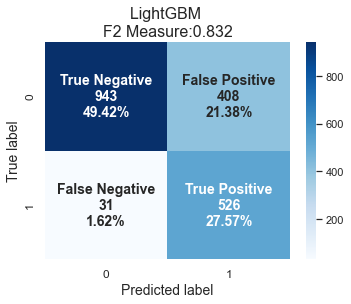

In [ ]:
def plot_cm(cf_matrix):
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5.5,4))
    return labels
   
labels = plot_cm(cm)

#plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',annot_kws={"size": 14, "weight":"semibold",  "family":'sans-serif'})
plt.title('LightGBM \nF2 Measure:{0:.3f}'.format(fbeta_score(y_test, y_test_pred, beta=2)), fontsize=16)
plt.ylabel('True label', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [13]:
importances = gbm.named_steps['m'].feature_importances_
df_importances = pd.DataFrame(data=importances, index=X_train.columns, columns=["importance"]).reset_index()

fig = px.bar(df_importances.query("importance > 50"),y="importance",x="index",color_discrete_sequence=["#0b3954"])
fig.update_xaxes(categoryorder='total descending')
fig.update_layout(title="<b>Most influential factors for attrition with LightGBM</b>", 
                  yaxis_title='Importance',
                  xaxis_title=None,
                  width=600,
                  height=350,
                  bargap=0.3,
                  barmode='group',
                  titlefont={'size': 18},           
                  )
fig.show()

NameError: name 'gbm' is not defined

### Model in action

In [ ]:
# Save model
file_name = 'Model Final.sav'
pickle.dump(gbm, open(file_name,'wb'))

In [ ]:
# Load model
loaded_model = pickle.load(open(file_name,'rb'))

In [ ]:
# Build a profile
df_predict = pd.DataFrame({
'promoted': [1],
'review': [0.7],
'projects': [3], 
'salary': [3], 
'satisfaction': [0.5],
'bonus':[1],
'avg_hrs_month': [130],
'department_IT': [1],
'department_admin': [0],
'department_engineering': [0],
'department_finance': [0],
'department_logistics': [0],
'department_marketing': [0],
'department_operations': [0],
'department_retail': [0],
'department_sales': [0],
'department_support': [0]
})

df_predict

In [ ]:
# Predict probilities
loaded_model.predict_proba(df_predict)

array([[0.35124487, 0.64875513]])